In [2]:
library(Seurat)
library(presto)
library(fgsea)
library(magick)
library(ggplot2)
library(colorRamp2)
library(ComplexHeatmap)
library(tidyr)
library(tibble)
library(dplyr)

### Load all data necessary for FigS4, FigS10

1. metadata with astrocyte subcluster label for each cell (astH1, astR1, etc.,)

In [3]:
all_metaData <- read.csv('/autofs/space/mindds_001/projects/AbbvieSnRNASeq/data/trajectory_analysis_2023/merged_metadata.csv')
rownames(all_metaData) <- all_metaData$X
clust_grp <- all_metaData[, c('X','cluster_group')]

2. Astrocytes sub-sampled by each region and stage (3000 per, in total 60,000, filter out non-labeled astrocytes)

In [38]:
obj <- readRDS('./merged_60000x39123_0418.RDS')

In [39]:
ast = CreateSeuratObject(counts = obj@assays[['RNA']]@counts, 
                         meta.data = obj@meta.data[c('SampleName','Unified_region','Donor.ID','Path..Group.')],
                         project = "ast", min.cells = 20)
rm(obj)

In [40]:
ast <- ast[,rownames(ast@meta.data) %in% rownames(clust_grp)]
ast@meta.data$Ast_clust <- clust_grp[rownames(ast@meta.data),'cluster_group']
ast <- ast %>%
    Seurat::NormalizeData(verbose = FALSE)

3. Temporal and Spatial gene sets, same with Fig3&4

In [17]:
fgsea_sets <- fgsea::gmtPathways("../genesets/Temporal_trajectory_gene_sets.gmt")
gs_df=as.data.frame(fgsea_sets[1])
gs_df$geneset='GS#1'
colnames(gs_df)<-c('Gene','GS')
for (i in c(2,3,4,5,6)){
    df <- as.data.frame(fgsea_sets[i])
    df$geneset=paste0('GS#',i)
    colnames(df)<-c('Gene','GS')
    gs_df <- rbind(gs_df,df)
}
rownames(gs_df) <- gs_df$Gene

In [18]:
sp_fgsea_sets <- fgsea::gmtPathways("../genesets/Spatial_trajectory_gene_sets.gmt")
sp_gs_df=as.data.frame(sp_fgsea_sets[1])
sp_gs_df$geneset='GS#1'
colnames(sp_gs_df)<-c('Gene','GS')
for (i in c(2,3,4,5,6)){
    df <- as.data.frame(sp_fgsea_sets[i])
    df$geneset=paste0('GS#',i)
    colnames(df)<-c('Gene','GS')
    sp_gs_df <- rbind(sp_gs_df,df)
}
rownames(sp_gs_df) <- sp_gs_df$Gene

### Plots for FigS4 and FigS10

1. **Fig4d**: intersection between Temporal and Spatial_trajectory_gene_sets

In [19]:
t_gs_list=c()
s_gs_list=c()
len_list=c()

for (tgs in names(fgsea_sets)){
    t_gs = paste0('GS#', strsplit(tgs,'#')[[1]][2])
    for (sgs in names(sp_fgsea_sets)){
        s_gs = paste0('GS#', strsplit(sgs,'#')[[1]][2])
        # intersect
        ilist_ <- list(intersect(fgsea_sets[[tgs]], sp_fgsea_sets[[sgs]]))
        t_gs_list = c(t_gs_list, t_gs)
        s_gs_list = c(s_gs_list, s_gs)
        len_list = c(len_list, length(ilist_[[1]]))
    }}
cm = as.data.frame(list(Temporal_trajectory_gene_sets=t_gs_list,
                        Spatial_trajectory_gene_sets=s_gs_list,
                         Freq=len_list))

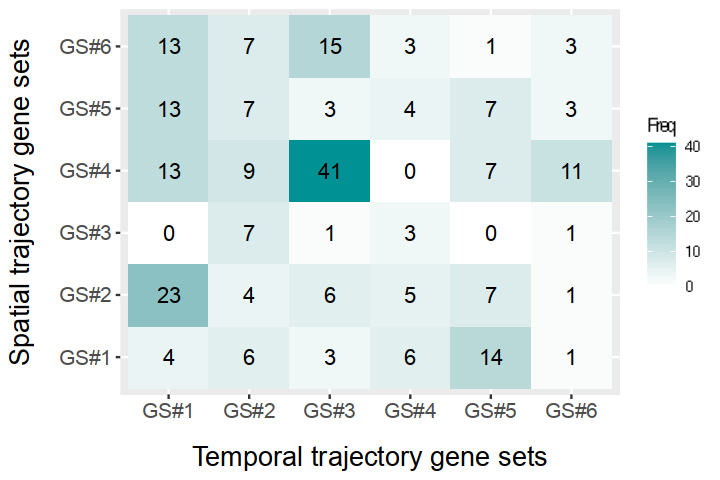

In [20]:
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot(cm, aes(Temporal_trajectory_gene_sets, 
               Spatial_trajectory_gene_sets, 
               fill= Freq)) +
        geom_tile() + geom_text(aes(label=Freq),size = 4.5,family='Arial') +
        scale_fill_gradient(low="white", high="#009194")+
        labs(x = "Temporal trajectory gene sets", y = "Spatial trajectory gene sets") +
        theme(axis.text = element_text(size = 12,family='Arial')) +
        theme(axis.title = element_text(size = 16,family='Arial')) +
        theme(axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0),family='Arial')) +
        theme(axis.title.y = element_text(margin = margin(t = 0, r = 15, b = 0, l = 0),family='Arial'))

2. **Fig4a**: Heatmap of logFC of spatial trajectory genes across 5 regions

In [21]:
Idents(object = ast) <- ast@meta.data$Unified_region
curr_gs = sp_gs_df

In [22]:
ast.genes <- wilcoxauc(ast)
hp_df = ast.genes[ast.genes$feature %in% curr_gs$Gene,]
# 3 col to matrix
hp_df = pivot_wider(hp_df[c('feature','group','logFC')], names_from = group, values_from = logFC)
mat <- as.matrix(hp_df[,2:dim(hp_df)[2]])
rownames(mat) <- hp_df$feature

In [23]:
curr_gs <- curr_gs[rownames(mat),]
row_dend = cluster_between_groups(t(mat), factor(curr_gs$GS))

In [24]:
lookup <- c('EC','ITG','PFC','V1','V2')
names(lookup) <- c('EC','BA20','BA46','V1','V2')
colnames(mat) <- lookup[colnames(mat)]

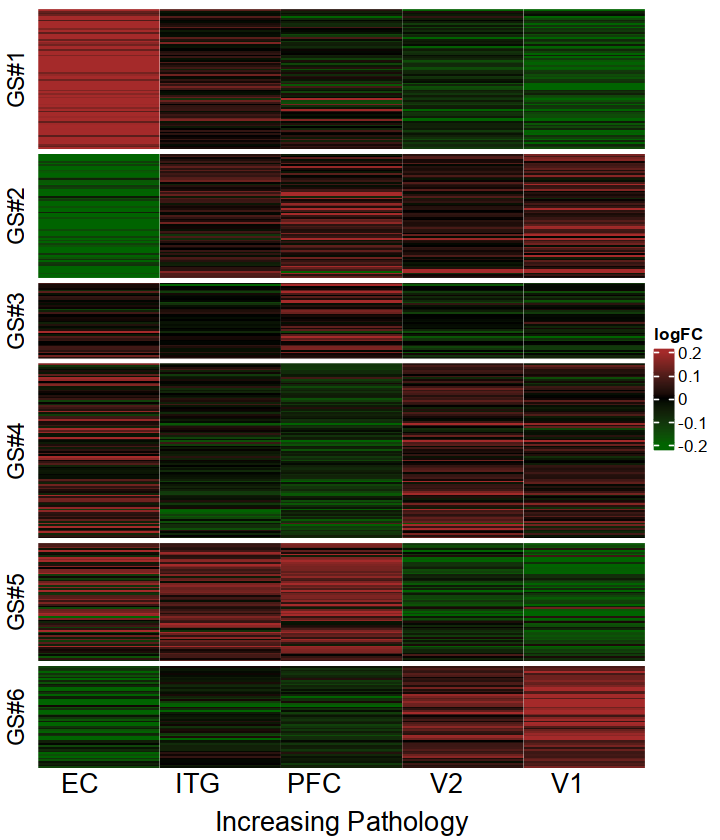

In [25]:
options(repr.plot.width=6, repr.plot.height=7)
pushViewport(viewport(gp = gpar(fontfamily = "Arial")))
ht = Heatmap(mat, 
        name='logFC',
        cluster_rows = F,
        row_split = factor(curr_gs$GS, levels = c('GS#1','GS#2','GS#3','GS#4','GS#5','GS#6')),
        #
        cluster_columns = FALSE, #column_split  = 3,
        column_split = factor(colnames(mat), levels = c('EC','ITG','PFC','V2','V1')),
        cluster_column_slices = FALSE,
        #
        row_gap = unit(1, "mm"),
        column_gap = unit(0, "mm"),
        #
        use_raster=TRUE, #raster_quality=100,
        raster_resize_mat = TRUE,
        raster_by_magick = TRUE,
        show_row_names=FALSE,
        column_names_rot = 0,
        column_names_gp = gpar(fontsize = 16),
        column_title="Increasing Pathology", column_title_side = "bottom",
        column_title_gp = gpar(fontsize = 16),
        col = colorRamp2(c(-0.2, 0, 0.2), c("darkgreen", "black", "brown")))
draw(ht, newpage = FALSE)
popViewport()

3. **Fig4b**: Heatmap of logFC of temporal trajectory genes across 4 stages

In [26]:
Idents(object = ast) <- ast@meta.data$Path..Group.
curr_gs = gs_df

In [27]:
ast.genes <- wilcoxauc(ast)
hp_df = ast.genes[ast.genes$feature %in% curr_gs$Gene,]
# 3 col to matrix
hp_df = pivot_wider(hp_df[c('feature','group','logFC')], names_from = group, values_from = logFC)
mat <- as.matrix(hp_df[,2:dim(hp_df)[2]])
rownames(mat) <- hp_df$feature

In [28]:
curr_gs <- curr_gs[rownames(mat),]
row_dend = cluster_between_groups(t(mat), factor(curr_gs$GS))

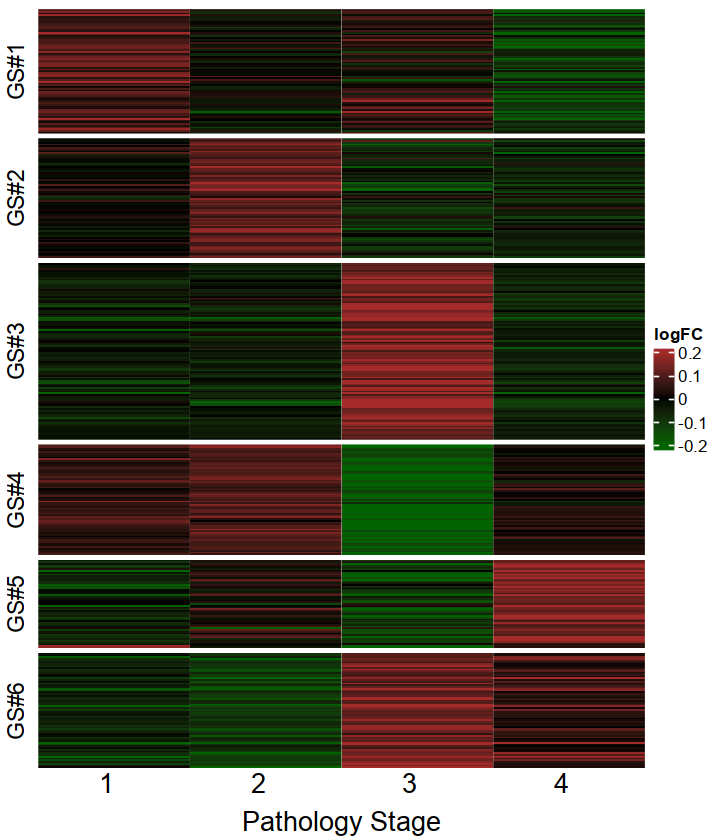

In [29]:
options(repr.plot.width=6, repr.plot.height=7)
pushViewport(viewport(gp = gpar(fontfamily = "Arial")))
ht = Heatmap(mat, 
        name='logFC',
        cluster_rows = F,
        row_split = factor(curr_gs$GS, levels = c('GS#1','GS#2','GS#3','GS#4','GS#5','GS#6')),
        #
        cluster_columns = FALSE,
        column_split = factor(colnames(mat), levels = c('1','2','3','4')),
        cluster_column_slices = FALSE,
        #
        row_gap = unit(1, "mm"),
        column_gap = unit(0, "mm"),
        #
        use_raster=TRUE, #raster_quality=100,
        raster_resize_mat = TRUE,
        raster_by_magick = TRUE,
        show_row_names=FALSE,
        column_names_rot = 0,
        column_names_gp = gpar(fontsize = 16),
        column_title="Pathology Stage", column_title_side = "bottom", #Increasing Pathology
        column_title_gp = gpar(fontsize = 16),
        col = colorRamp2(c(-0.2, 0, 0.2), c("darkgreen", "black", "brown")))
draw(ht, newpage = FALSE)
popViewport()

4. **FigS10a**: Spatial gene sets enrichment of each Ast subcluster

In [41]:
Idents(object = ast) <- ast@meta.data$Ast_clust

In [42]:
ast.genes <- wilcoxauc(ast)

In [48]:
fgsea_result = c()
for (grp in unique(ast.genes$group)){
    ### rank genes of curr grp
    grp.genes <- ast.genes %>%
        dplyr::filter(group == grp) %>%
        arrange(desc(logFC), desc(padj)) %>%  #, desc(auc)
        dplyr::select(feature, logFC)
    ranks<- deframe(grp.genes)
    ### gsea
    fgseaRes <- fgsea(sp_fgsea_sets, 
                      stats = ranks, nPermSimple = 10000)
    grp.fgsea <- fgseaRes %>%
              as_tibble() %>%
              arrange(desc(NES)) %>%
              dplyr::select(-leadingEdge, -ES) %>%  #-nMoreExtreme
              arrange(padj)
    grp.fgsea$Cluster <- grp
    fgsea_result <- rbind(fgsea_result, grp.fgsea)
}

In [49]:
fgsea_result$Cluster <- factor(fgsea_result$Cluster, levels = sort(unique(ast@meta.data$Ast_clust)))
fgsea_result$pathway <- factor(fgsea_result$pathway, levels = rev(names(fgsea_sets)))
fgsea_result$padj[fgsea_result$padj<1e-3]=1e-3

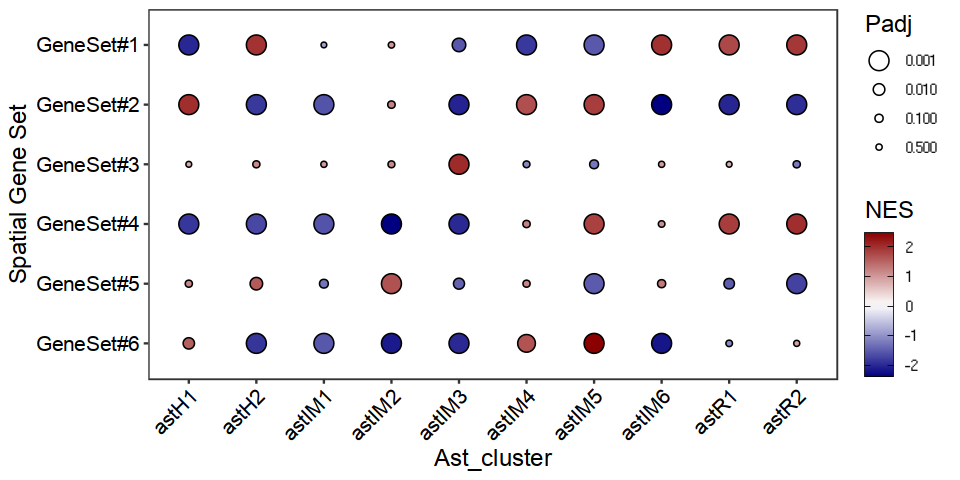

In [50]:
dot_plot <- ggplot(fgsea_result, aes(x=Cluster, y=pathway)) +
      geom_point(aes(size = padj, fill = NES), color="black", shape=21) +
      scale_size("Padj", trans="log10", range=c(5, 1), breaks=c(1e-3, 1e-2, 1e-1,0.5)) +
      scale_fill_gradientn(colours = colorRampPalette(c('navy','white','darkred'), bias=1)(20),#viridisLite::mako(100),
                       guide = guide_colorbar(ticks.colour = "black",
                                              frame.colour = "black"),
                       name = "NES") +
      ylab("Spatial Gene Set") + xlab("Ast_cluster") +
      theme_bw() +
      theme(axis.text.x = element_text(size=12, angle=45, hjust=1, color="black",family='Arial'),
            axis.text.y = element_text(size=12, color="black",family='Arial'),
            axis.title = element_text(size=14,family='Arial'),
            legend.title=element_text(size=14, color="black",family="Arial"),
           panel.grid=element_blank())
options(repr.plot.width = 8, repr.plot.height = 4)
dot_plot

5. **FigS10b**: Temporal gene sets enrichment of each Ast subcluster

In [55]:
fgsea_result = c()
for (grp in unique(ast.genes$group)){
    ### rank genes of curr grp
    grp.genes <- ast.genes %>%
        dplyr::filter(group == grp) %>%
        arrange(desc(logFC), desc(padj)) %>%  #, desc(auc)
        dplyr::select(feature, logFC)
    ranks<- deframe(grp.genes)
    ### gsea
    fgseaRes <- fgsea(fgsea_sets, stats = ranks, nPermSimple = 10000)#, nperm = 10000
    grp.fgsea <- fgseaRes %>%
              as_tibble() %>%
              arrange(desc(NES)) %>%
              dplyr::select(-leadingEdge, -ES) %>%  #-nMoreExtreme
              arrange(padj)
    grp.fgsea$Cluster <- grp
    fgsea_result <- rbind(fgsea_result, grp.fgsea)
}

In [56]:
fgsea_result$Cluster <- factor(fgsea_result$Cluster, levels = sort(unique(ast@meta.data$Ast_clust)))
fgsea_result$pathway <- factor(fgsea_result$pathway, levels = rev(names(fgsea_sets)))
fgsea_result$padj[fgsea_result$padj<1e-3]=1e-3

In [57]:
dot_plot <- ggplot(fgsea_result, aes(x=Cluster, y=pathway)) +
      geom_point(aes(size = padj, fill = NES), color="black", shape=21) +
      scale_size("Padj", trans="log10", range=c(5, 1), breaks=c(1e-3, 1e-2, 1e-1,0.5)) +
      scale_fill_gradientn(colours = colorRampPalette(c('navy','white','darkred'), bias=1)(20),#viridisLite::mako(100),
                       guide = guide_colorbar(ticks.colour = "black",
                                              frame.colour = "black"),
                       name = "NES") +
      ylab("Temporal Gene Set") + xlab("Ast_cluster") +
      theme_bw() +
      theme(axis.text.x = element_text(size=12, angle=45, hjust=1, color="black",family='Arial'),
            axis.text.y = element_text(size=12, color="black",family='Arial'),
            axis.title = element_text(size=14,family='Arial'),
            legend.title=element_text(size=14, color="black",family="Arial"),
           panel.grid=element_blank())

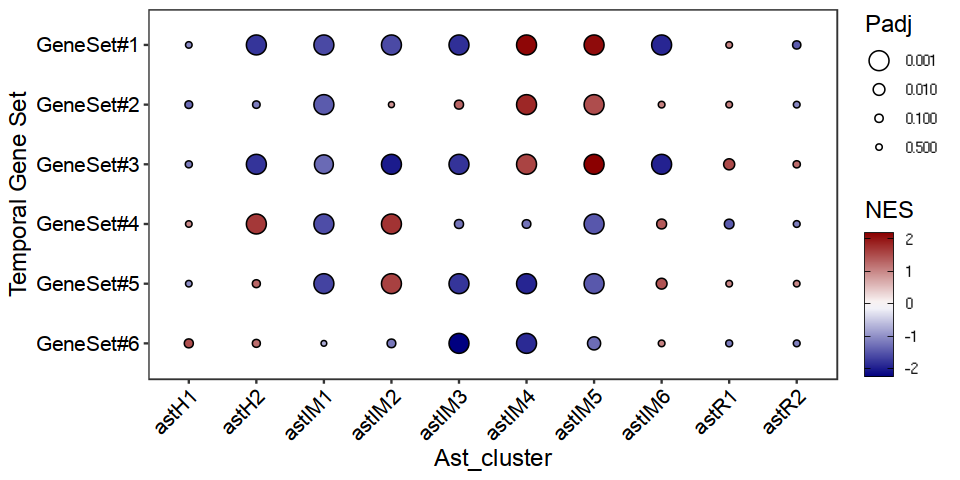

In [58]:
options(repr.plot.width = 8, repr.plot.height = 4)
dot_plot